# Simple Example

**Simple example demonstrating SQL column lineage analysis**

### Imports

In [1]:
from clgraph import SQLColumnTracer

# Example SQL query with CTE and joins
sql = """
WITH monthly_sales AS (
  SELECT
    user_id,
    DATE_TRUNC(order_date, MONTH) as month,
    SUM(amount) as total_amount,
    COUNT(*) as order_count
  FROM orders
  WHERE status = 'completed'
  GROUP BY 1, 2
),
user_stats AS (
  SELECT
    user_id,
    AVG(total_amount) as avg_monthly_sales,
    MAX(order_count) as max_orders
  FROM monthly_sales
  GROUP BY user_id
)
SELECT
  u.name,
  u.email,
  us.avg_monthly_sales,
  us.max_orders,
  CASE
    WHEN us.avg_monthly_sales > 1000 THEN 'high'
    WHEN us.avg_monthly_sales > 500 THEN 'medium'
    ELSE 'low'
  END as customer_tier
FROM users u
JOIN user_stats us ON u.id = us.user_id
WHERE u.active = true
"""

### Code

In [2]:
print("SQL Column Lineage Example")
print()

# Create tracer and analyze the query
tracer = SQLColumnTracer(sql, dialect="bigquery")
lineage = tracer.build_column_lineage_graph()

print("Query Analysis Complete!")
print()


# Helper function to trace backward lineage
def get_backward_lineage(graph, column_name):
    """Find all source columns for a given output column"""
    sources = set()

    # Find the output node
    output_node = None
    for node in graph.get_output_nodes():
        if node.column_name == column_name:
            output_node = node
            break

    if not output_node:
        return sources

    # Traverse backward through edges
    def trace_back(node):
        for edge in graph.get_edges_to(node):
            from_node = edge.from_node
            if from_node.layer == "input":
                sources.add(from_node.full_name)
            else:
                trace_back(from_node)

    trace_back(output_node)
    return sources


# Helper function to trace forward lineage
def get_forward_lineage(graph, source_name):
    """Find all output columns affected by a source column"""
    impacts = set()

    # Find the source node
    source_node = None
    for node in graph.get_input_nodes():
        if node.full_name == source_name or node.column_name == source_name.split(".")[-1]:
            source_node = node
            break

    if not source_node:
        return impacts

    # Traverse forward through edges
    def trace_forward(node):
        for edge in graph.get_edges_from(node):
            to_node = edge.to_node
            if to_node.layer == "output":
                impacts.add(to_node.column_name)
            else:
                trace_forward(to_node)

    trace_forward(source_node)
    return impacts

SQL Column Lineage Example

Query Analysis Complete!



### Example 1: Find sources for an output column

In [3]:
print("1. BACKWARD LINEAGE (Where does 'avg_monthly_sales' come from?)")
sources = get_backward_lineage(lineage, "avg_monthly_sales")
for source in sorted(sources):
    print(f"  → {source}")
print()

1. BACKWARD LINEAGE (Where does 'avg_monthly_sales' come from?)
  → orders.amount



### Example 2: Find impacts of a source column

In [4]:
print("2. FORWARD LINEAGE (What uses 'orders.amount'?)")
impacts = get_forward_lineage(lineage, "orders.amount")
for impact in sorted(impacts):
    print(f"  → {impact}")
print()

2. FORWARD LINEAGE (What uses 'orders.amount'?)
  → avg_monthly_sales
  → customer_tier



### Example 3: Get all output columns

In [5]:
print("3. OUTPUT COLUMNS")
output_cols = lineage.get_output_nodes()
for col in output_cols:
    print(f"  • {col.column_name}")
print()

3. OUTPUT COLUMNS
  • name
  • email
  • avg_monthly_sales
  • max_orders
  • customer_tier



### Example 4: Get all source tables

In [6]:
print("4. SOURCE TABLES")
input_nodes = lineage.get_input_nodes()
source_tables = {node.table_name for node in input_nodes if node.table_name}
for source in sorted(source_tables):
    print(f"  • {source}")
print()

4. SOURCE TABLES
  • orders
  • users



### Example 5: Column with transformation logic

In [7]:
print("5. COLUMN WITH TRANSFORMATION")
print("Column: customer_tier")
tier_sources = get_backward_lineage(lineage, "customer_tier")
print(f"Depends on: {', '.join(sorted(tier_sources))}")
print()

print("Analysis complete! See the lineage object for more details.")

5. COLUMN WITH TRANSFORMATION
Column: customer_tier
Depends on: orders.amount

Analysis complete! See the lineage object for more details.


### Visualize Column Lineage

Display the column lineage graph showing how data flows from source tables through CTEs to output columns.

Full Column Lineage Graph:


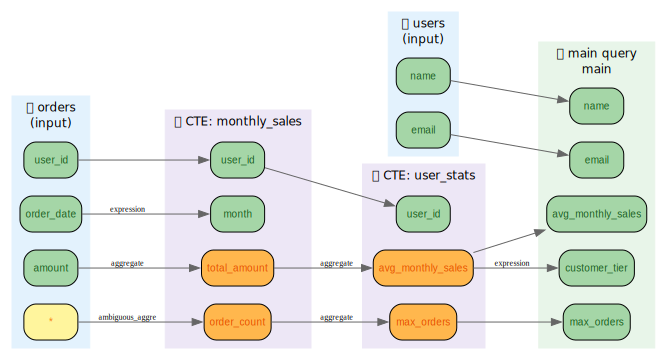

In [8]:
import shutil

from clgraph import visualize_column_lineage

# Check if graphviz is available
if shutil.which("dot") is None:
    print("⚠️  Graphviz not installed. Install with: brew install graphviz")
    print("   Skipping visualization...")
else:
    # Visualize the full column lineage graph
    print("Full Column Lineage Graph:")
    display(visualize_column_lineage(lineage))

Simplified Lineage (Input → Output):


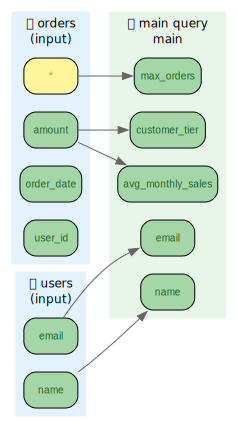

In [9]:
# Simplified view: Input → Output only (hide intermediate layers)
if shutil.which("dot") is not None:
    print("Simplified Lineage (Input → Output):")
    display(visualize_column_lineage(lineage.to_simplified()))